## Import CSVs

## in the actual folder must be the notebook
## then create a folder Data and in this folder create 3 folders:
## test_images_from_train
## train_images_model
## validation_images_model
## then add the test.csv and train.csv also in the Data folder
## the csv can be found here https://github.com/cvdfoundation/google-landmark




In [2]:
import numpy as np 
import pandas as pd 
import sys, requests, shutil, os
data=pd.read_csv('./Data/train.csv')
test_data = pd.read_csv('./Data/test.csv')
data.head(5)

,id,url,landmark_id
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474


## Sample the data

In [5]:
#set number range (1000-2000)  to 203090
first =202050
second=203090

landmark_list = [x for x in list(range(first,second))]
data_sample = data[data['landmark_id'].isin(landmark_list)]

#data_sample.landmark_id.value_counts()

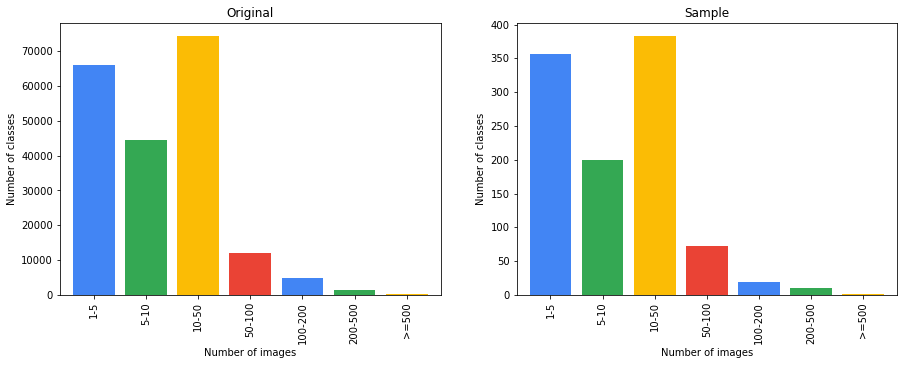

In [6]:
# Check data distribution
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import subplots

colors = np.array(['#4285f4','#34a853','#fbbc05','#ea4335'])
#Define the order in which to display the graph
order = ['1-5','5-10','10-50','50-100','100-200','200-500','>=500']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))


def plot_distribution(data_f, data_k, axis):
    # data['landmark_id'].value_counts()
    x=data_f.landmark_id.value_counts().index
    y=pd.DataFrame(data_f.landmark_id.value_counts())
  
    #Create a variable to group the number of image sin each class
    y['Number of images'] = np.where(y['landmark_id']>=500,'>=500',y['landmark_id'])
    
    y['Number of images'] = np.where((y['landmark_id']>=200) & (y['landmark_id']<500),'200-500',y['Number of images'])
    #if np.where(y['landmark_id']>=200):
       # print(y['landmark_id'])
    y['Number of images'] = np.where((y['landmark_id']>=100) & (y['landmark_id']<200),'100-200',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=50) & (y['landmark_id']<100),'50-100',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=10) & (y['landmark_id']<50),'10-50',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=5) & (y['landmark_id']<10),'5-10',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=0) & (y['landmark_id']<5),'1-5',y['Number of images'])

    
    y['Number of images'].value_counts().loc[order].plot(kind = 'bar',color = colors,width = 0.8, ax=axis)
    axis.set_xlabel('Number of images')
    axis.set_ylabel('Number of classes')
    axis.set_title(data_k)
    
plot_distribution(data, 'Original', ax1)
plot_distribution(data_sample, 'Sample', ax2)



## Download Images


In [54]:
#Ref: https://www.kaggle.com/lyakaap/fast-resized-image-download-python-3
import re
TARGET_SIZE = 224 #imports images of resolution 224x224

'''change URLs to resize images to target size'''
def overwrite_urls(df):
    def reso_overwrite(url_tail, reso=TARGET_SIZE):
        pattern = 's[0-9]+'
        search_result = re.match(pattern, url_tail)
        if search_result is None:
            return url_tail
        else:
            return 's{}'.format(reso)
    
    def join_url(parsed_url, s_reso):
        parsed_url[-2] = s_reso
        return '/'.join(parsed_url)
    
    df = df[df.url.apply(lambda x: len(x.split('/'))>1)]
    parsed_url = df.url.apply(lambda x: x.split('/'))
    train_url_tail = parsed_url.apply(lambda x: x[-2])
    resos = train_url_tail.apply(lambda x: reso_overwrite(x, reso=TARGET_SIZE))

    overwritten_df = pd.concat([parsed_url, resos], axis=1)
    overwritten_df.columns = ['url', 's_reso']
    df['url'] = overwritten_df.apply(lambda x: join_url(x['url'], x['s_reso']), axis=1)
    return df

data_sample_resize = overwrite_urls(data_sample)
print ('1. URLs overwritten')

'''Split to test and train'''
data_test = pd.DataFrame(columns = ['id','url','landmark_id'])
data_training_all = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_test = 0.01 #takes 1% from each class as holdout data

import random
random.seed(42)
for landmark_id in set(data_sample_resize['landmark_id']):
    n=1
    t = data_sample_resize[(data_sample_resize.landmark_id == landmark_id)] #get all images for a landmark id
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])  #create a list of all these images
        i += 1
        
    test = random.sample(r,int(percent_test*len(r))) #randomly pick a sample of 1% images from list 'r'
    training = list(set(r) - set(test))  #get the remaining images
    data_t = data_sample_resize[data_sample_resize.id.isin(test)] #holdout dataset
    data_tr = data_sample_resize[data_sample_resize.id.isin(training)] #training dataset
    data_test = data_test.append(data_t)  
    data_training_all = data_training_all.append(data_tr)
    n+=1

print ('2. train and test set created')


'''Split into train and validation set'''
data_valid = pd.DataFrame(columns = ['id','url','landmark_id'])
data_train = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_validation = 0.2 #takes 20% from each class as holdout data
import random
random.seed(42)
for landmark_id in set(data_training_all['landmark_id']):
    n=1
    t = data_training_all[(data_training_all.landmark_id == landmark_id)]
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])
        i += 1
        
    valid = random.sample(r,int(percent_validation*len(r)))
    train = list(set(r) - set(valid)) 
    data_v = data_training_all[data_training_all.id.isin(valid)]
    data_t = data_training_all[data_training_all.id.isin(train)]
    data_valid = data_valid.append(data_v)
    data_train = data_train.append(data_t)
    n+=1

print ('3. train and validation set created')
print (len(data_train))
print (len(data_valid))
print (len(data_test))

1. URLs overwritten
2. train and test set created
3. train and validation set created
4100
928
16


Create directories 'train_images_model', 'validation_images_model', 'test_images_from_train' inside 'Data' folder before running the code ahead.

In [ ]:
def fetch_image(path,folder):
    url=path
    response=requests.get(url, stream=True)
    with open('./Data/' + folder + '/image.jpg', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    
    
'''TRAIN SET - fetch images for the resized URLs and save in the already created directory train_images_model'''
i=0
for link in data_train['url']:              #looping over links to get images
    try:
        if os.path.exists('./Data/train_images_model/'+str(data_train['id'].iloc[i])+'.jpg'):
            i+=1
            continue
        fetch_image(link,'train_images_model')
        #img = Image.open('./Data/train_images_model/'+ str(data_train['id'].iloc[i])+ '.jpg')
        os.rename('./Data/train_images_model/image.jpg','./Data/train_images_model/'+ str(data_train['id'].iloc[i])+ '.jpg')
        i+=1
    except:
        #i+=1
        pass
#     if(i==50):   #uncomment to test in your machine
#         break
print('4. train images fetched')

    
i=0
for link in data_valid['url']:              #looping over links to get images
    try:
        if os.path.exists('./Data/validation_images_model/'+str(data_valid['id'].iloc[i])+'.jpg'):
            i+=1
            continue
        fetch_image(link,'validation_images_model')
        #img = Image.open('./Data/validation_images_model/'+ str(data_train['id'].iloc[i])+ '.jpg')    
        os.rename('./Data/validation_images_model/image.jpg','./Data/validation_images_model/'+ str(data_valid['id'].iloc[i])+ '.jpg')                               
        i+=1
    except:
        #i+=1
        pass
#     if(i==50):   #uncomment to test in your machine
#         break
print('5. Validation images fetched')

i=0
for link in data_test['url']:  #looping over links to get images
    try:
        if os.path.exists('./Data/test_images_from_train/'+str(data_test['id'].iloc[i])+'.jpg'):
            i+=1
            continue
        fetch_image(link,'test_images_from_train')
        #img = Image.open('./Data/test_images_from_train/'+ str(data_train['id'].iloc[i])+ '.jpg')
        os.rename('./Data/test_images_from_train/image.jpg','./Data/test_images_from_train/'+ str(data_test['id'].iloc[i])+ '.jpg')
        i+=1
    except:
        #i+=1
        pass
#     if(i==50):   #uncomment to test in your machine
#         break
print('6. Test images fetched')

4. train images fetched


In [56]:
import os
path, dirs, files = next(os.walk("./Data/train_images_model/"))
file_count = len(files)
print(file_count)

4100


In [57]:
#remove empty or defect images from train
from PIL import Image
i=0
for link in data_train['url']: 
  
    try:
        img = Image.open('./Data/train_images_model/'+ str(data_train['id'].iloc[i])+ '.jpg')
        i+=1
      
    except:
        os.remove('./Data/train_images_model/'+ str(data_train['id'].iloc[i])+ '.jpg')
        #print("removed"+ str(data_train['id'].iloc[i]))
        i+=1
        pass
    
from PIL import Image
i=0
for link in data_valid['url']: 
    try:
        
        #print("ok")
        img = Image.open('./Data/validation_images_model/'+ str(data_valid['id'].iloc[i])+ '.jpg')
        i+=1
    except:
        os.remove('./Data/validation_images_model/'+ str(data_valid['id'].iloc[i])+ '.jpg')
        #print("removed"+ str(data_valid['id'].iloc[i]))
        i+=1
        pass
    
#remove empty or defect images from test
from PIL import Image
i=0
for link in data_test['url']: 
    try:
        img = Image.open('./Data/test_images_from_train/'+ str(data_test['id'].iloc[i])+ '.jpg')
        i+=1
      
    except:
        os.remove('./Data/test_images_from_train/'+ str(data_test['id'].iloc[i])+ '.jpg')
        #print("removed"+ str(data_test['id'].iloc[i]))
        i+=1
        pass

In [58]:
import os
path, dirs, files = next(os.walk("./Data/train_images_model/"))
file_count = len(files)
print(file_count)

463


## Data Preprocessing
Creating folders for each landmark ID (Class label)

In [59]:
##create folders for landmark IDs in Training folder
import pandas as pd
import os
import shutil
from shutil import copyfile
import urllib

train_data = data_train

temp = pd.DataFrame(data_train.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']

def createfolders(dataset,folder):
    i = 0
    while i < len(dataset):
        landmark = str(dataset.landmark_id.iloc[i])
        path = './Data/' + folder + '/'+ landmark
        if not os.path.exists(path):
            os.makedirs(path)
        i+=1
createfolders(temp,'train_images_model')
print ('Train folders created')

rootdirpics = r'./Data/train_images_model/'
rootdirfolders = r'./Data/train_images_model/'

def transformdata(data,path1, path2):

    n = 1
    for landmark_id in set(data['landmark_id']):
        t = data[(data.landmark_id == landmark_id)]
        i = 1
        r =[]
        while i <= len(t.id):
            it = i - 1
            r.append(t.id.iloc[it])
            i += 1
        for files in os.listdir(rootdirpics):    # loop through startfolders
            inpath = path1 + files
            folder = str(landmark_id)
            outpath = path2 + folder  
            if ((files.split('.')[0] in r) & (os.path.getsize(inpath) >1000)):
#                 print('move')
                shutil.move(inpath, outpath)
            elif ((files.split('.')[0] in r) & (os.path.getsize(inpath) <= 1000)):
                os.remove(inpath)
        n+=1

transformdata(train_data,rootdirpics, rootdirfolders)
print ('Train images moved')

Train folders created
Train images moved


In [60]:
##create folders for landmark IDs in Validation folder

temp = pd.DataFrame(data_valid.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
createfolders(temp,'validation_images_model')
print ('Validation folders created')

#make folders for landmark ID which had no images in validation sets - required for codes running next
available = [int((x[0].split('/'))[-1]) for x in os.walk(r'./Data/validation_images_model/') if len((x[0].split('/'))[-1]) > 0]
new = [str(x) for x in range(first,second) if x not in available]
for i in new:
    path = './Data/validation_images_model/' + i
    if not os.path.exists(path):
        os.makedirs(path)

rootdirpics = r'./Data/validation_images_model/'
rootdirfolders = r'./Data/validation_images_model/'
transformdata(data_valid,rootdirpics, rootdirfolders)
print ('Validation images moved')

Validation folders created
Validation images moved


In [ ]:
import os
import shutil

#you can define only to use landmarks with more then x pictures only change the 30 to your limit
for x in range(first, second+1):
    print(x) 
    path, dirs, files = next(os.walk("./Data/train_images_model/"+str(x)+"/"))
    file_count = len(files)
    if file_count < 30:
        print(file_count)
        shutil.rmtree("./Data/train_images_model/"+str(x))
        shutil.rmtree("./Data/validation_images_model/"+str(x))

   

# Model Training - Transfer Learning

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import Model
import csv
import os
from keras.models import load_model
import matplotlib.pyplot as plt
import math
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import tensorflow as tf
import keras
from keras import applications



Using TensorFlow backend.


#### Compile and train the entire model

In [ ]:
img_width, img_height = 224, 224
top_model_weights_path = 'test.h5'
train_data_dir = './Data/train_images_model'
validation_data_dir = './Data/validation_images_model'
batch_size = 240
epochs = 50
def trainCNN():

    # build the VGG16 network

    base_model = applications.VGG16(weights='imagenet',include_top= False,input_shape=(224,224,3))

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dense(256, activation='relu'))
    n_class = second-first
    top_model.add(Dense(n_class, activation='softmax'))
    #top_model.load_weights(top_model_weights_path) #Load the weights initialized in previous steps
    

    model = Model(input= base_model.input, output= top_model(base_model.output))
    
    # set the first 16 layers to non-trainable (weights will not be updated) - 1 conv layer and three dense layers will be trained
    for layer in model.layers[:16]:
        layer.trainable = False

    # compile the model with a SGD/momentum optimizer and a very slow learning rate.
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.001, beta_1=0.9,beta_2=0.999,epsilon=1e-8, decay=0.0),
                  metrics=['accuracy'])
    print ('Compilation done.')
    
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=90,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        zoom_range = 0.5)
    
    valid_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    #np.save('class_indices.npy', train_generator.class_indices)

    validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')
    
    #hier unbedingt die Anzahl eurer Bilder (trainings bilder und validation bilder) eintragen
    steps_per_epoch = 474 // batch_size
    validation_steps = 107 // batch_size
   
    print ('Model fit begins...')
    model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[ModelCheckpoint(filepath="test.h5", save_best_only=True, save_weights_only=True)]
        )
  
    

trainCNN()

In [13]:
## prediction

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

#paste path to your test image there
img_path1 = r'./Data/train_images_model/1050/a735574833ff88ac.jpg'

img1 = image.load_img(img_path1, target_size= (224,224))
x1 = image.img_to_array(img1)
x1 = np.expand_dims(x1, axis = 0)
x1 = preprocess_input(x1)

label_map = (train_generator.class_indices)
print(label_map)
preds = model.predict(x1)
y_classes = preds.argmax(axis=-1)
print(y_classes)
print(model.predict_on_batch(x1))

#print ('Predicted:', decode_predictions(preds, top = 3))
model.summary()
result = model.predict_on_batch(x1)
#pred=model.predict_classes(x1)
print(result)
#print(preds)

for category, value in train_generator.class_indices.items():
            
            if value == preds.argmax():
                print(preds.argmax())
                print(category)

import matplotlib.pyplot as pllt
%matplotlib inline
pllt.plot(oke.history['acc'])
pllt.plot(oke.history['val_acc'])
pllt.title('Accuracy with number of epochs')
pllt.ylabel('accuracy %')
pllt.xlabel('Number of epoch')
pllt.legend(['acc', 'val_acc'])
pllt.show()